__Churn Prediction__
Retention Rate is one of the most critical metrics.Retention Rate is an indication of how good is your product market fit (PMF).
If your PMF is not satisfactory, you should see your customers churning very soon. One of the powerful tools to improve 
Retention Rate (hence the PMF) is Churn Prediction.

we will use a Telco dataset and go over the following steps to develop a Churn Prediction model:
- Exploratory data analysis
- Feature engineering
- Investigating how the features affect Retention by using Logistic Regression
- Building a classification model with XGBoost

In [14]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [15]:
df_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [16]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

__Exploratory Data Analysis__

In [17]:
df_data.loc[df_data.Churn=='No','Churn'] = 0 
df_data.loc[df_data.Churn=='Yes','Churn'] = 1

In [18]:
df_data.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [19]:
df_plot = df_data.groupby('gender').Churn.mean().reset_index()
df_plot

,gender,Churn
0,Female,0.269209
1,Male,0.261603


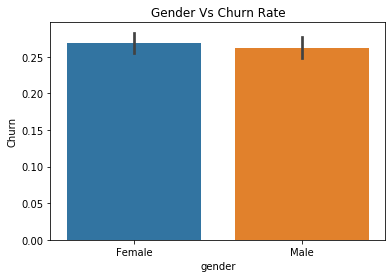

In [20]:
sns.barplot(x='gender',y='Churn',data=df_data)
plt.title("Gender Vs Churn Rate")
plt.xticks((0,1),("Female","Male"))
plt.show()

In [21]:
df_plot = df_data.groupby('InternetService').Churn.mean().reset_index()
df_plot

,InternetService,Churn
0,DSL,0.189591
1,Fiber optic,0.418928
2,No,0.074050


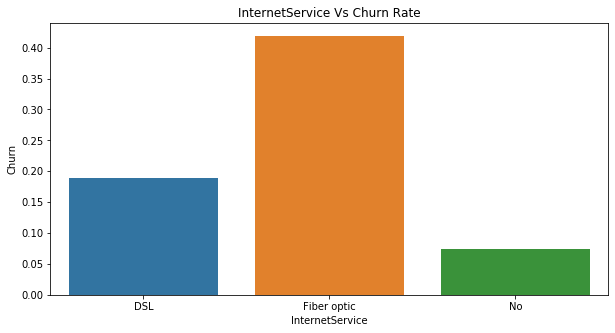

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x='InternetService',y='Churn',data=df_plot)
plt.title("InternetService Vs Churn Rate")
plt.show()

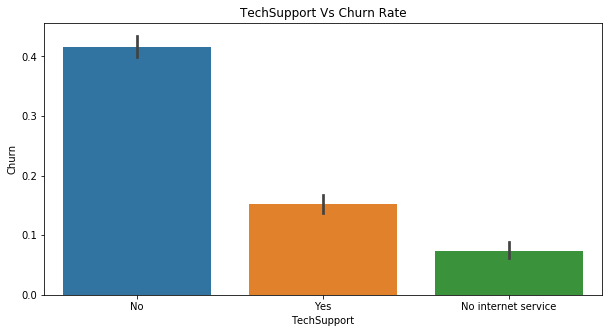

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(x='TechSupport',y='Churn',data=df_data)
plt.title("TechSupport Vs Churn Rate")
plt.show()

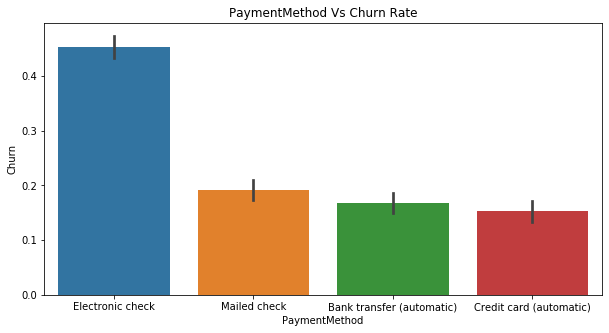

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(x='PaymentMethod',y='Churn',data=df_data)
plt.title("PaymentMethod Vs Churn Rate")
plt.show()

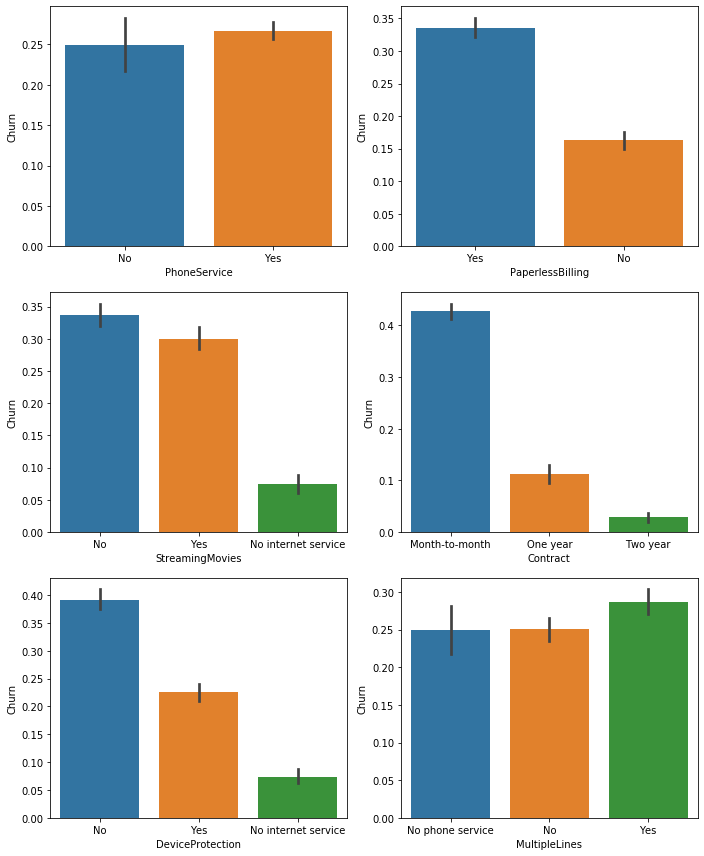

In [25]:
fig = plt.figure(figsize=(10,12))
labels2 = ['PhoneService','PaperlessBilling','StreamingMovies','Contract','DeviceProtection','MultipleLines']  
for i in range(0,6):
    ax = fig.add_subplot(3,2,i+1)
    plt.tight_layout()
    sns.barplot(x=labels2[i],y='Churn',data=df_data)
plt.show()

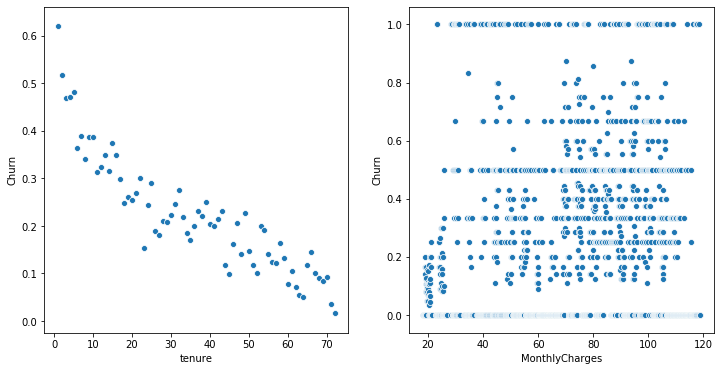

In [70]:
fig = plt.figure(figsize=(12,6))
labels2 = ['tenure','MonthlyCharges']  
for i in range(0,2):
    ax = fig.add_subplot(1,2,i+1)
    #plt.tight_layout()
    df_plot = df_data.groupby(labels2[i]).Churn.mean().reset_index()
    sns.scatterplot(x=labels2[i],y='Churn',data=df_plot)
plt.show()

In [66]:
#df_plot = df_data.groupby('TotalCharges').Churn.mean().reset_index()

2

In [73]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

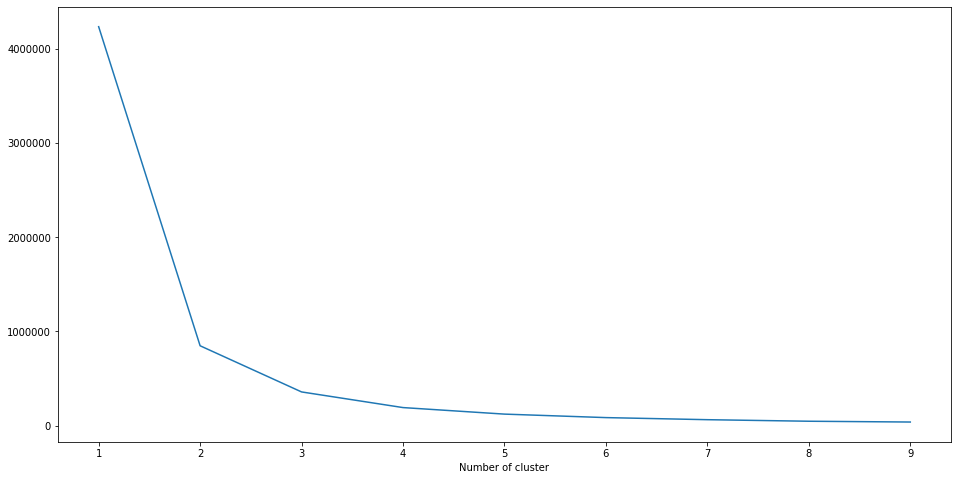

In [74]:
sse={}
pd.options.mode.chained_assignment = None
df_cluster = df_data[['tenure']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(16,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [75]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['tenure']])
df_data['TenureCluster'] = kmeans.predict(df_data[['tenure']])

In [76]:
df_data = order_cluster('TenureCluster', 'tenure',df_data,True)

In [77]:
df_data.groupby('TenureCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,2930.0,7.830717,6.220431,1.0,2.0,6.0,13.0,21.0
1,1929.0,34.792120,8.297679,22.0,27.0,35.0,42.0,49.0
2,2173.0,63.475380,7.172433,50.0,57.0,65.0,70.0,72.0


In [78]:
df_data['TenureCluster'] = df_data["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

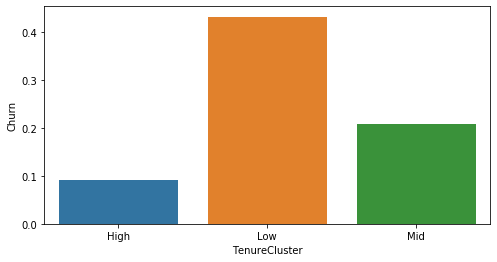

In [82]:
df_plot = df_data.groupby('TenureCluster').Churn.mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='TenureCluster',y='Churn',data=df_plot)
plt.show()

In [35]:
df_plot = df_data.copy()
df_plot['MonthlyCharges'] = df_plot['MonthlyCharges'].astype(int)
df_plot = df_plot.groupby('MonthlyCharges').Churn.mean().reset_index()

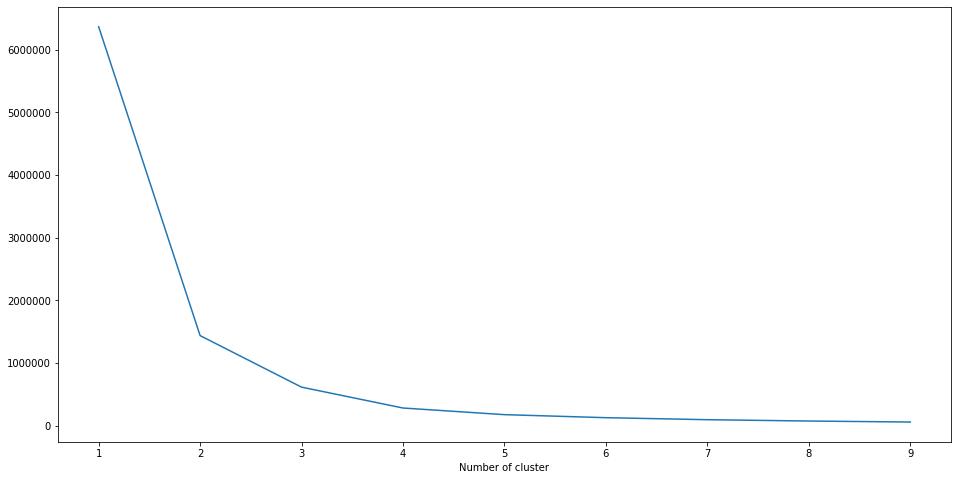

In [84]:
sse={}
df_cluster = df_data[['MonthlyCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(16,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [85]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['MonthlyCharges']])
df_data['MonthlyChargeCluster'] = kmeans.predict(df_data[['MonthlyCharges']])

In [86]:
df_data = order_cluster('MonthlyChargeCluster', 'MonthlyCharges',df_data,True)

In [87]:
df_data.groupby('MonthlyChargeCluster').MonthlyCharges.describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargeCluster,,,,,,,,
0,1886.0,23.389608,5.666778,18.25,19.800,20.40,25.050,42.40
1,2235.0,61.630000,10.445398,42.60,51.775,61.55,70.700,77.80
2,2911.0,94.058794,10.342824,77.85,85.075,93.90,101.925,118.75


In [90]:
df_data['MonthlyChargeCluster'] = df_data["MonthlyChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

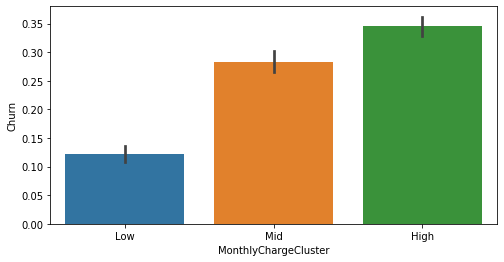

In [96]:
plt.figure(figsize=(8,4))
sns.barplot(x='MonthlyChargeCluster',y='Churn',data=df_data)
plt.show()

In [91]:
df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,TenureCluster_Mid,MonthlyChargeCluster_High,MonthlyChargeCluster_Low,MonthlyChargeCluster_Mid,TotalChargeCluster_High,TotalChargeCluster_Low,TotalChargeCluster_Mid,proba,TenureCluster,MonthlyChargeCluster


In [92]:
len(df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()])

0

In [93]:
df_data.loc[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull(),'TotalCharges'] = np.nan

In [94]:
df_data = df_data.dropna()

In [95]:
df_data['TotalCharges'] = pd.to_numeric(df_data['TotalCharges'], errors='coerce')

In [97]:
df_plot = df_data.copy()
df_plot['TotalCharges'] = df_plot['TotalCharges'].astype(int)

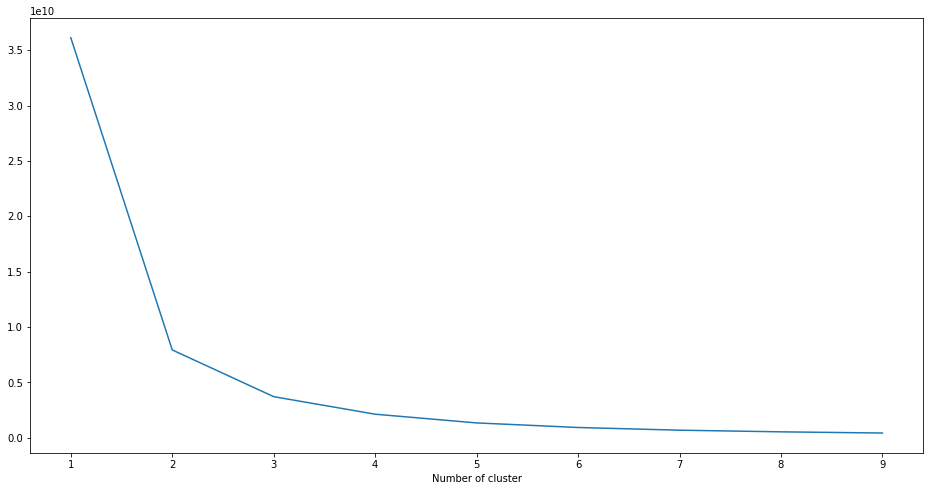

In [99]:
sse={}
df_cluster = df_data[['TotalCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(16,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [100]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['TotalCharges']])
df_data['TotalChargeCluster'] = kmeans.predict(df_data[['TotalCharges']])

In [101]:
df_data = order_cluster('TotalChargeCluster', 'TotalCharges',df_data,True)

In [102]:
df_data.groupby('TotalChargeCluster').TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargeCluster,,,,,,,,
0,4160.0,686.204087,572.025502,18.80,161.4875,535.95,1139.4125,1975.85
1,1613.0,3272.602139,814.144302,1978.65,2548.6500,3211.20,3970.4000,4779.45
2,1259.0,6292.972558,1003.372938,4783.50,5468.7000,6145.85,7040.1500,8684.80


In [103]:
df_data['TotalChargeCluster'] = df_data["TotalChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})

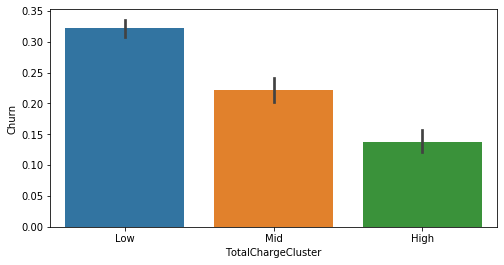

In [104]:
plt.figure(figsize=(8,4))
sns.barplot(x='TotalChargeCluster',y='Churn',data=df_data)
plt.show()

In [105]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 55 columns):
customerID                                 7032 non-null object
gender                                     7032 non-null int32
SeniorCitizen                              7032 non-null int64
Partner                                    7032 non-null int32
Dependents                                 7032 non-null int32
tenure                                     7032 non-null int64
PhoneService                               7032 non-null int32
PaperlessBilling                           7032 non-null int32
MonthlyCharges                             7032 non-null float64
TotalCharges                               7032 non-null float64
Churn                                      7032 non-null int64
MultipleLines_No                           7032 non-null uint8
MultipleLines_No_phone_service             7032 non-null uint8
MultipleLines_Yes                          7032 non-null uint8
Intern

In [106]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns

for column in df_data.columns:
    if df_data[column].dtype == object and column != 'customerID':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column]) 
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
df_data = pd.get_dummies(data = df_data,columns = dummy_columns)

In [107]:
df_data[['gender','Partner','TenureCluster_High','TenureCluster_Low','TenureCluster_Mid']].head()

,gender,Partner,TenureCluster_High,TenureCluster_High,TenureCluster_Low,TenureCluster_Low,TenureCluster_Mid,TenureCluster_Mid
0,0,1,0,0,1,1,0,0
1,0,0,0,0,1,1,0,0
2,1,0,0,0,1,1,0,0
3,1,0,0,0,1,1,0,0
4,1,1,0,0,1,1,0,0


In [108]:
all_columns = []
for column in df_data.columns:
    column = column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_")
    all_columns.append(column)

df_data.columns = all_columns

In [109]:
glm_columns = 'gender'

for column in df_data.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

In [110]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
 

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=df_data, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                            GLM   Df Residuals:                     6997
Model Family:                Binomial   Df Model:                           34
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 07 Dec 2019   Deviance:                          nan
Time:                        10:13:39   Pearson chi2:                 8.85e+18
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:942: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:942: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:942: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:943: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
C:\Users\Mehul Sharma\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:943: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


In [111]:
np.exp(res.params)

Intercept                                  inf
gender                                     inf
SeniorCitizen                              0.0
Partner                                    0.0
Dependents                                 inf
tenure                                     0.0
PhoneService                               inf
PaperlessBilling                           0.0
MonthlyCharges                             0.0
TotalCharges                               inf
MultipleLines_No                           inf
MultipleLines_No_phone_service             0.0
MultipleLines_Yes                          inf
InternetService_DSL                        0.0
InternetService_Fiber_optic                inf
InternetService_No                         0.0
OnlineSecurity_No                          inf
OnlineSecurity_No_internet_service         0.0
OnlineSecurity_Yes                         inf
OnlineBackup_No                            0.0
OnlineBackup_No_internet_service           0.0
OnlineBackup_

In [112]:
import xgboost as xgb

In [60]:
#create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)
#building the model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))
y_pred = xgb_model.predict(X_test)

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.79


In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       260
           1       0.60      0.54      0.57        92

    accuracy                           0.79       352
   macro avg       0.72      0.71      0.71       352
weighted avg       0.78      0.79      0.78       352



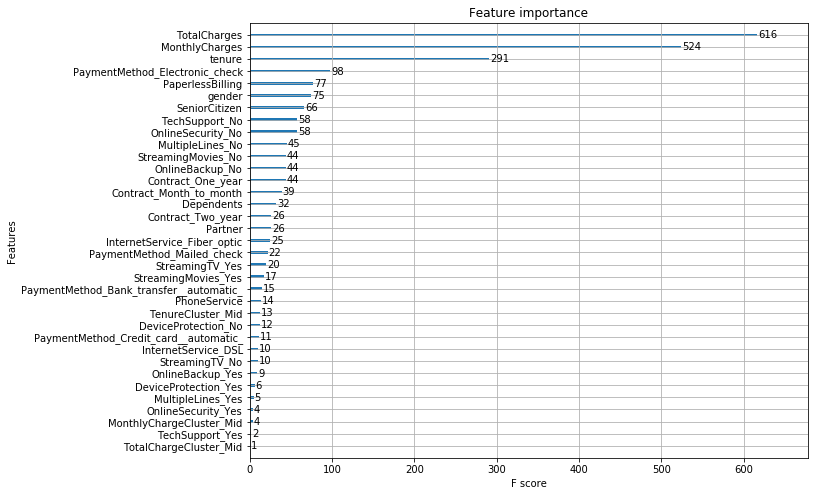

In [62]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

In [63]:
df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]
df_data[['customerID', 'proba']].head()

,customerID,proba
0,7590-VHVEG,0.580691
1,6713-OKOMC,0.175894
2,7469-LKBCI,0.016826
3,8779-QRDMV,0.915089
4,1680-VDCWW,0.038087
